In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

logging.langsmith('LangGraph-Module')
load_dotenv()

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Module


True

In [2]:
from langchain_community.tools import TavilySearchResults

tool = TavilySearchResults(
    max_results=5
)

tools = [tool]

# print(tool.invoke("랭체인 테디노트 튜토리얼"))

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import add_messages

class State(TypedDict):
    # Annotated는 타입에 대한 추가적인 제약사항이나 메타데이터를 제공하는 데 사용.
    messages: Annotated[list, add_messages]

llm 정의 및 도구 바인딩

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm_with_tools = llm.bind_tools(tools)

노드 정의

In [5]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])

    return {"messages": [answer]}

그래프 생성 및 노드 추가

In [6]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

## 도구 노드 정의

도구가 호출될 경우, 실제로 실행할 수 있는 함수. 새로운 노드에 도구 추가.<br>
가장 최근 메시지를 확인하고 메시지에 tool_calls가 포함되어 있는 경우 도구를 호출하는 BasicToolNode 구현.<br>
LangGraph에 pre-built 되어 있는 ToolNode로 대체 가능.

In [7]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """
    Run tools requested in the AImessages node.
    """

    def __init__(self, tools:list) ->  None:
        self.tools_list = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call['name']].invoke(tool_call['args'])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content = json.dumps(
                        tool_result, ensure_ascii=False
                    ),
                    name = tool_call['name'],
                    tool_call_id = tool_call['id'],
                )
            )
        return {"messages": outputs}

# 도구 노드 생성    
tool_node = BasicToolNode(tools = [tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

## 조건부 엣지(Conditional Edge)

도구 노드가 추가되면 conditional edge를 정의할 수 있다.<br>
일반적으로 'if' 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅한다. 이러한 함수는 현재 그래프 state를 받아 다음에 호출할 node를 나태는 문자열 또는 문자열 목록을 반환.<br>
**add_conditional_edges**를 호출하여 그래프에 추가.<Br>
조건은 도구 호출이 있으면 tools로, 없으면 END로 라우팅.

- 참고
langgraph 에 pre-built 되어 있는 tools_condition 으로 대체 가능.

### 매개변수

- source (str): 시작 노드, 이 노드를 나갈 때 조건부 엣지 실행.
- path(Union[Callable, Runnable]): 다음 노드를 결정하는 호출 가능한 객체 또는 Runnable. path_map을 지정하지 않으면 하나 이상의 노드를 반환해야 한다. END 를 반환하면 그래프 실행 중지.
- path_map(Optional[Union[dic[Hashable,str], list[str]]]): 경로와 노드 이름 간의 매핑. 생략하면 path가 반환하는 값이 노드 이름이어야 함.
- then(Optional[str]): path로 선택된 노드 실행 후 실행할 노드의 이름.

### 반환값
- self: 메서드 체이닝을 위해 자기 자신을 반환.

### 주요기능
1. 조건부 엣지를 그래프에 추가.
2. path_map을 딕셔너리로 변환
3. path 함수의 변환 타입을 분석하여 자동으로 path_map을 생성할 수 있다.
4. 조건부 분기를 그래프에 저장.


### 참고

- 이미 컴파일된 그래프에 엣지를 추가하면 경고 메시지가 출력됩니다.
- path 함수의 반환 값에 대한 타입 힌트가 없거나 path_map이 제공되지 않으면, 그래프 시각화 시 해당 엣지가 그래프의 모든 노드로 전환될 수 있다고 가정합니다.
- 동일한 이름의 분기가 이미 존재하는 경우 ValueError가 발생합니다.

In [8]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

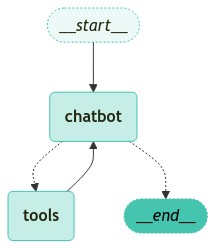

In [9]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [10]:
inputs = {"messages": "테디노트 YouTube 채널에 대해서 검색해 줘"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])


STEP: messages

content='테디노트 YouTube 채널에 대해서 검색해 줘' additional_kwargs={} response_metadata={} id='2a60933d-ce90-4ad0-acd8-53a67cb87ce7'

STEP: messages

content='' additional_kwargs={'tool_calls': [{'id': 'call_GWfhqkA7tJd0H2WkQ6b4Lbng', 'function': {'arguments': '{"query":"테디노트 YouTube 채널"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 93, 'total_tokens': 118, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-9e5d7c88-e97e-4107-8703-22ee0e11ae23-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '테디노트 YouTube 채널'}, 'id': 'call_GWfhqkA7tJd0H2WkQ6b4Lbng', 'type': 'tool